## 데이터 불러오기

In [27]:
spark.stop()

In [10]:
from pyspark.sql import SparkSession
import os
import glob
import json
import boto3
from botocore.exceptions import NoCredentialsError
from dotenv import load_dotenv

load_dotenv()

# AWS S3 정보
BUCKET_NAME = os.getenv('BUCKET_NAME')
ACCESS_KEY = os.getenv('AWS_ACCESS_KEY_ID')
SECRET_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
REGION_NAME = "ap-northeast-2"


def download_s3_file(remote_path, local_path):
    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)
    try:
        s3.download_file(BUCKET_NAME, remote_path, local_path)
    except NoCredentialsError:
        raise Exception("AWS credentials not available")

# 로컬 디렉토리 생성
os.makedirs('data', exist_ok=True)

# S3 파일 다운로드
download_s3_file('jobplanet/year=2023/month=08/day=14/jobplanet.json', 'data/jobplanet.json')
download_s3_file('jumpit/year=2023/month=08/day=12/jumpit.json', 'data/jumpit.json')
download_s3_file('rallit/year=2023/month=08/day=12/rallit.json', 'data/rallit.json')
download_s3_file('wanted/year=2023/month=08/day=12/wanted.json', 'data/wanted.json')

In [15]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark EDA #1") \
    .config("spark.jars", "/usr/local/lib/python3.10/dist-packages/pyspark/jars/redshift-jdbc42-2.1.0.14.jar") \
    .getOrCreate()

In [16]:
# 현재 디렉토리의 data 폴더에 있는 모든 JSON 파일의 경로를 가져옵니다.
file_path = glob.glob(f'{os.getcwd()}/data/*.json')

if not file_path:
    raise ValueError("No JSON files found in the specified directory!")

file_path

['/home/jovyan/data/jobplanet.json',
 '/home/jovyan/data/jumpit.json',
 '/home/jovyan/data/rallit.json',
 '/home/jovyan/data/wanted.json']

In [22]:
# JSON 파일 읽어서 DataFrame 생성
data = []
for path in file_path:
    with open(path) as json_file:
        json_data = json.load(json_file)
        # 키 이름 변경
        if "result" in json_data:
            data.append(path)
            

In [25]:
data

['/home/jovyan/data/jobplanet.json',
 '/home/jovyan/data/jumpit.json',
 '/home/jovyan/data/rallit.json',
 '/home/jovyan/data/wanted.json']

In [23]:
# 모든 JSON 파일을 한 번에 읽어 DataFrame 생성
df = spark.read.option("multiline", "true").json(data)

In [24]:
df.show()

+----------------------------+
|                      result|
+----------------------------+
|[{, 웹 개발자, 포그리트, ...|
| [{null, 서버/백엔드 개발...|
|      [{null, CTO, (주)로...|
|  [{NodeJS 기반의 글로벌 ...|
+----------------------------+



In [26]:
# "results" 배열을 DataFrame의 행으로 변환
df_results = df.selectExpr("explode(result) as results")

# 각 필드에 대해 DataFrame 컬럼으로 분리
df_final = df_results.select(
    "results.job_id",
    "results.platform",
    "results.category",
    "results.url",
    "results.company",
    "results.title",
    "results.primary_responsibility",
    "results.required",
    "results.preferred",
    "results.end_at",
    "results.skills",
    "results.location",
    "results.welfare",
    "results.body",
    "results.company_description",
    "results.coordinate"
)

In [34]:
# 결과 확인
df_final.show()

+------+--------+---------+--------------------+---------------------------------+-----------------------------+----------------------------------+------------------------------+-------------------------------+----------+--------------------+----------------------------------+-----------------------------------+----+----------------------------------+--------------------+
|job_id|platform| category|                 url|                          company|                        title|            primary_responsibility|                      required|                      preferred|    end_at|              skills|                          location|                            welfare|body|               company_description|          coordinate|
+------+--------+---------+--------------------+---------------------------------+-----------------------------+----------------------------------+------------------------------+-------------------------------+----------+--------------------+--------

In [111]:
df_final.toPandas()

,job_id,platform,category,url,company,title,primary_responsibility,required,preferred,end_at,skills,location,welfare,body,company_description,coordinate
0,175689,wanted,웹 개발자,https://www.wanted.co.kr/wd/175689,포그리트,Sr. Frontend Developer,"• 포그리트의 메인 서비스(UX heatmap, Journey Map)의 신규 기능...","• 최소 5년 이상의 웹 개발 경험 필수 ( HTML, CSS, JavaScript...","• 컴퓨터공학, 전산과 관련 학위를 소지 하신 분\n• MongoDB, Elast...",None,[],"경기도 성남시 분당구 판교역로 136 (판교역, 힐스테이트) 판매시설 1100호",• 연 1회 건강검진 \n• 야근 식대 지원\n• 매년 야근 예방 접종 지원\n• ...,,"[조직소개]\n포그리트는 고객의 형태를 빅데이터로 재구성하여, 그로스 해킹을 돕는 ...","[37.3920843, 127.109167]"
1,175689,wanted,웹 개발자,https://www.wanted.co.kr/wd/175689,포그리트,Sr. Frontend Developer,"• 포그리트의 메인 서비스(UX heatmap, Journey Map)의 신규 기능...","• 최소 5년 이상의 웹 개발 경험 필수 ( HTML, CSS, JavaScript...","• 컴퓨터공학, 전산과 관련 학위를 소지 하신 분\n• MongoDB, Elast...",None,[],"경기도 성남시 분당구 판교역로 136 (판교역, 힐스테이트) 판매시설 1100호",• 연 1회 건강검진 \n• 야근 식대 지원\n• 매년 야근 예방 접종 지원\n• ...,,"[조직소개]\n포그리트는 고객의 형태를 빅데이터로 재구성하여, 그로스 해킹을 돕는 ...","[37.3920843, 127.109167]"
2,175657,wanted,웹 개발자,https://www.wanted.co.kr/wd/175657,위메이드(WEMADE),"스마트컨트랙트 개발(DeFi / Lending, Crypto Dollar, DEX)",• 블록체인 DeFi 서비스를 위한 스마트 컨트랙트 개발\n• Kleva(Lendi...,• 관련 학과 전공 (컴퓨터 공학 / 수학 / 금융공학 등) 또는 개발 경력 1년 ...,• DeFi 서비스를 이용해보신 분\n• 관련 경력 3년 이상 서비스 플랫폼 개발 ...,2023-11-10,[],경기도 성남시 분당구 대왕판교로 644번길 49 위메이드타워,#조식제공 #중식제공 #건강검진 #단체보험 #사내카페 #복지카드 #요가룸 #수면실\...,,위메이드는 20여 년간 게임업계에서 활약해 왔습니다.\n\n미르4를 성공적으로 출시...,"[37.4014343, 127.1122219]"
3,175550,wanted,웹 개발자,https://www.wanted.co.kr/wd/175550,일진씨앤에스,MES & QMS 시스템운영(개발),• 솔루션 기반 QMS 시스템 개발 및 운영\n• 설비 인터페이스 관리 및 오류 수정,"• C#, C++ 프로그램 개발 가능\n• Oracle 데이터베이스 활용 가능\n•...","• 관련 자격증 소지\n• MES(생산관리), QMS(품질관리) 및 EMS(설비관리...",None,[],전북 익산시 석암로3길 63-25,"• 경조휴가 및 경조금 지원, 장기근속 포상, 우수사원 포상\n• 고등학교/대학교 ...",,일진그룹의 Total IT Solution 회사인 일진씨앤에스에서 경력사원을 채용합니다.,"[35.9540045, 127.0010682]"
4,175408,wanted,웹 개발자,https://www.wanted.co.kr/wd/175408,채널코퍼레이션,[채널톡] Web (Frontend) Software Engineer 신사업팀,[무엇을 만드나요?]\n\n신사업 앱 서비스에 들어가는 웹뷰와 고객사가 사용하는 고...,[이런 분을 찾고있어요] \n• 자주 새로운 도전 과제들이 생깁니다. 가지 않은 길...,• 웹 뷰 경험이 있으신 분,None,[],"강남구 논현로 508, GS강남타워",[이렇게 대우합니다]\n• 채널팀은 의미 있는 성과를 낸 멤버에게 '업계 최고'의 ...,,[어떤 팀인가요?]\n\n채널코퍼레이션은 고객과 브랜드 사이의 문제를 찾고 해결하고...,"[37.5018187, 127.0370947]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17333,970,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/970,(주)아이비스,"Embedded SW개발 C++,C 개발자 모집",". 컴퓨터 프로그래밍 언어로 각 업무에 맞는 SW의 기능에 관한 설계, 구현 및 테...",. Linux 기반의 Embedded SW 개발 경험\n. Linux 기반 Clie...,. Linux/ rtOS 기반 차량용 SW개발 경험\n. C++11/14 개발경험\n,9999-12-31,"[C++, C, 임베디드, Linux]",경기 수원시 영통구 대학4로 17,WORK & LIFE\n• 근태: '금요일 12시 퇴근! 오전 10시 출근!'내 맘...,차량용 SW개발자를 모집합니다.,"""Future mobility SW in vehicle"" \n- 차량에 탑재되는 소...","[37.3001653, 127.0467106]"
17334,1633,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/1633,(주)라피치,[AI음성기술전문기업] 시스템 엔지니어(신입/경력),ㆍAWS 클라우드 기반 시스템 구축 및 운영\nㆍ서버 및 스토리지 등 시스템 구축 ...,"ㆍ서버, 스토리지, 네트워크, 데이터베이스 등 시스템 기술에 대한 지식과 경험 보유...",ㆍ3년 이상의 시스템 엔지니어링 경력 또는 해당 분야 관련 전공 학위 소지\nㆍAW...,9999-12-31,"[Linux, AWS]",서울 강남구 도곡로8길 6,[근무환경]\n ㆍPC 및 듀얼모니터 제공\n ㆍ유연근무제 (근무 시간을 선택해서 ...,시스템 보안 및 안정성을 유지하고 개선하기 위하여 설계 및 구축 등의 역할을 합니다.,'라피치'는 AI 음성기술의 오랜 연구개발과 기술력을 바탕으로\n현재 화자인증 시스...,"[37.490147, 127.0350462]"
17335,771,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/771,(주)모카시스템,임베디드 펌웨어 개발자,- Airfob Space 디바이스 Firmware 개발\n- Embedded Li...,- 펌웨어 개발 경험 3년 이상 또는 그에 준하는 이해도를 갖추신 분\n- Embe...,"출입 통제, 근태 관리, 경보 시스템 또는 보안 관련 경험이 있으신 분",9999-12-31,"[임베디드, Linux, C, C++, Qt]",경기 성남시 분당구 성남대로331번길 8,효율적인 업무 집중을 위해\n- 주 4.5일 근무제(매 주 금요일 4시간 30분 근...,출입통제 시스템의 불편함을 해결하기 위해 최초의 100% 클라우드 기반 모바일 출입...,출입통제 시스템의 불편함을 해결하기 위해 최초의 100% 클라우드 기반 모바일 출입...,"[37.3659481, 127.1066323]"
17336,1490,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/1490,더블디,"[더블디] ESP32 펌웨어, 회로설계 개발자 채용 공고",- ESP32 펌웨어 및 하드웨어 개발 보조\n- 자주 사용하는 기능 에셋화 / 모...,- Python 및 C언어 사용 능숙\n- ESP32 개발 경험 보유(우대사항),"- Nordic, STM, ATMega 등 다양한 MCU 처리 경험(우대사항)"

In [35]:
df_final.printSchema()

root
 |-- job_id: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- category: string (nullable = true)
 |-- url: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- primary_responsibility: string (nullable = true)
 |-- required: string (nullable = true)
 |-- preferred: string (nullable = true)
 |-- end_at: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- location: string (nullable = true)
 |-- welfare: string (nullable = true)
 |-- body: string (nullable = true)
 |-- company_description: string (nullable = true)
 |-- coordinate: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [36]:
df_final.rdd.getNumPartitions()

4

## 데이터 정제

### 중복 컬럼 확인하기

In [42]:
from pyspark.sql.functions import col

In [43]:
# Finding duplicates based on job_id
duplicates = df_final.filter(col("job_id")
                             .isin(df_final.groupBy("job_id")
                                   .count().filter("count > 1")
                                   .select("job_id")
                                   .rdd.flatMap(lambda x: x)
                                   .collect()))

In [44]:
# Finding duplicates based on job_id and company
new_duplicates = df_final.filter((col("job_id") + col("company"))
                                 .isin(df_final.groupBy("job_id", "company")
                                       .count()
                                       .filter("count > 1")
                                       .select((col("job_id") + col("company"))
                                               .alias("combined"))
                                       .rdd.flatMap(lambda x: x)
                                       .collect()))

In [41]:
# Sorting duplicates by job_id
duplicates = duplicates.orderBy("job_id")

In [47]:
duplicates

DataFrame[job_id: string, platform: string, category: string, url: string, company: string, title: string, primary_responsibility: string, required: string, preferred: string, end_at: string, skills: array<string>, location: string, welfare: string, body: string, company_description: string, coordinate: array<double>]

In [110]:
duplicates.toPandas()

,job_id,platform,category,url,company,title,primary_responsibility,required,preferred,end_at,skills,location,welfare,body,company_description,coordinate
0,175689,wanted,웹 개발자,https://www.wanted.co.kr/wd/175689,포그리트,Sr. Frontend Developer,"• 포그리트의 메인 서비스(UX heatmap, Journey Map)의 신규 기능...","• 최소 5년 이상의 웹 개발 경험 필수 ( HTML, CSS, JavaScript...","• 컴퓨터공학, 전산과 관련 학위를 소지 하신 분\n• MongoDB, Elast...",None,[],"경기도 성남시 분당구 판교역로 136 (판교역, 힐스테이트) 판매시설 1100호",• 연 1회 건강검진 \n• 야근 식대 지원\n• 매년 야근 예방 접종 지원\n• ...,,"[조직소개]\n포그리트는 고객의 형태를 빅데이터로 재구성하여, 그로스 해킹을 돕는 ...","[37.3920843, 127.109167]"
1,175689,wanted,웹 개발자,https://www.wanted.co.kr/wd/175689,포그리트,Sr. Frontend Developer,"• 포그리트의 메인 서비스(UX heatmap, Journey Map)의 신규 기능...","• 최소 5년 이상의 웹 개발 경험 필수 ( HTML, CSS, JavaScript...","• 컴퓨터공학, 전산과 관련 학위를 소지 하신 분\n• MongoDB, Elast...",None,[],"경기도 성남시 분당구 판교역로 136 (판교역, 힐스테이트) 판매시설 1100호",• 연 1회 건강검진 \n• 야근 식대 지원\n• 매년 야근 예방 접종 지원\n• ...,,"[조직소개]\n포그리트는 고객의 형태를 빅데이터로 재구성하여, 그로스 해킹을 돕는 ...","[37.3920843, 127.109167]"
2,175657,wanted,웹 개발자,https://www.wanted.co.kr/wd/175657,위메이드(WEMADE),"스마트컨트랙트 개발(DeFi / Lending, Crypto Dollar, DEX)",• 블록체인 DeFi 서비스를 위한 스마트 컨트랙트 개발\n• Kleva(Lendi...,• 관련 학과 전공 (컴퓨터 공학 / 수학 / 금융공학 등) 또는 개발 경력 1년 ...,• DeFi 서비스를 이용해보신 분\n• 관련 경력 3년 이상 서비스 플랫폼 개발 ...,2023-11-10,[],경기도 성남시 분당구 대왕판교로 644번길 49 위메이드타워,#조식제공 #중식제공 #건강검진 #단체보험 #사내카페 #복지카드 #요가룸 #수면실\...,,위메이드는 20여 년간 게임업계에서 활약해 왔습니다.\n\n미르4를 성공적으로 출시...,"[37.4014343, 127.1122219]"
3,175550,wanted,웹 개발자,https://www.wanted.co.kr/wd/175550,일진씨앤에스,MES & QMS 시스템운영(개발),• 솔루션 기반 QMS 시스템 개발 및 운영\n• 설비 인터페이스 관리 및 오류 수정,"• C#, C++ 프로그램 개발 가능\n• Oracle 데이터베이스 활용 가능\n•...","• 관련 자격증 소지\n• MES(생산관리), QMS(품질관리) 및 EMS(설비관리...",None,[],전북 익산시 석암로3길 63-25,"• 경조휴가 및 경조금 지원, 장기근속 포상, 우수사원 포상\n• 고등학교/대학교 ...",,일진그룹의 Total IT Solution 회사인 일진씨앤에스에서 경력사원을 채용합니다.,"[35.9540045, 127.0010682]"
4,175408,wanted,웹 개발자,https://www.wanted.co.kr/wd/175408,채널코퍼레이션,[채널톡] Web (Frontend) Software Engineer 신사업팀,[무엇을 만드나요?]\n\n신사업 앱 서비스에 들어가는 웹뷰와 고객사가 사용하는 고...,[이런 분을 찾고있어요] \n• 자주 새로운 도전 과제들이 생깁니다. 가지 않은 길...,• 웹 뷰 경험이 있으신 분,None,[],"강남구 논현로 508, GS강남타워",[이렇게 대우합니다]\n• 채널팀은 의미 있는 성과를 낸 멤버에게 '업계 최고'의 ...,,[어떤 팀인가요?]\n\n채널코퍼레이션은 고객과 브랜드 사이의 문제를 찾고 해결하고...,"[37.5018187, 127.0370947]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13373,1734,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/1734,주식회사 모빌테크,센서 융합 연구원 (신입/경력),"ㆍ센서 시스템 및 맵핑 시스템 셋업\nㆍ센서 데이터 (Camera, LiDAR, G...",ㆍC / C++ Programming\nㆍROS Programming\nㆍLinux...,"ㆍ네트워크에 대한 이해도가 있으신 분\nㆍ센서 활용 경험\n - (LiDAR, G...",9999-12-31,"[C, C++, Linux]",서울 서초구 마방로4길 16-9,**자율적인 회사 문화**\n- 출퇴근 시간을 내맘대로! 주 40시간 근무와 팀별 ...,----------------------------------------------...,모빌테크는 AI를 기반으로 3D 공간 정보를 다루는 스타트업입니다.\n공간을 있는 ...,"[37.4733296, 127.0407797]"
13374,970,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/970,(주)아이비스,"Embedded SW개발 C++,C 개발자 모집",". 컴퓨터 프로그래밍 언어로 각 업무에 맞는 SW의 기능에 관한 설계, 구현 및 테...",. Linux 기반의 Embedded SW 개발 경험\n. Linux 기반 Clie...,. Linux/ rtOS 기반 차량용 SW개발 경험\n. C++11/14 개발경험\n,9999-12-31,"[C++, C, 임베디드, Linux]",경기 수원시 영통구 대학4로 17,WORK & LIFE\n• 근태: '금요일 12시 퇴근! 오전 10시 출근!'내 맘...,차량용 SW개발자를 모집합니다.,"""Future mobility SW in vehicle"" \n- 차량에 탑재되는 소...","[37.3001653, 127.0467106]"
13375,1633,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/1633,(주)라피치,[AI음성기술전문기업] 시스템 엔지니어(신입/경력),ㆍAWS 클라우드 기반 시스템 구축 및 운영\nㆍ서버 및 스토리지 등 시스템 구축 ...,"ㆍ서버, 스토리지, 네트워크, 데이터베이스 등 시스템 기술에 대한 지식과 경험 보유...",ㆍ3년 이상의 시스템 엔지니어링 경력 또는 해당 분야 관련 전공 학위 소지\nㆍAW...,9999-12-31,"[Linux, AWS]",서울 강남구 도곡로8길 6,[근무환경]\n ㆍPC 및 듀얼모니터 제공\n ㆍ유연근무제 (근무 시간을 선택해서 ...,시스템 보안 및 안정성을 유지하고 개선하기 위하여 설계 및 구축 등의 역할을 합니다.,'라피치'는 AI 음성기술의 오랜 연구개발과 기술력을 바탕으로\n현재 화자인증 시스...,"[37.490147, 127.0350462]"
13376,771,rallit,HARDWARE_EMBEDDED_ENGINEER,https://www.rallit.com/positions/771,(주)모카시스템,임베디드 펌웨어 개발자,- Airfob Space 디바이스 Firmware 개발\n- Embedded Li...,- 펌웨어 개발 경험 3년 이상 또는 그에 준하는 이해도를 갖추신 분\n- Embe...,"출입 통제, 근태 관리, 경보 시스템 또는 보안 관련 경험이 있으신 분",9999-12-31,"

In [50]:
from pyspark.sql.functions import count

In [54]:
duplicates.count()

13378

In [55]:
new_duplicates.count()

0

In [53]:
# Check if the lengths of new_duplicates and duplicates are the same
are_lengths_equal = new_duplicates.count() == duplicates.count()
print(f"플랫폼별로 겹치는 job_id는 없음: {are_lengths_equal}")

# Print the number of duplicate data
print(f'중복된 데이터의 개수는: {duplicates.count() // 2}개')

# Print the number of job posts after excluding duplicate data
print(f'중복 데이터를 제외한 채용공고 수는 : {df_final.count() - (duplicates.count() // 2)}개')

플랫폼별로 겹치는 job_id는 없음: False
중복된 데이터의 개수는: 6689개
중복 데이터를 제외한 채용공고 수는 : 10649개


### 대분류, 중분류 카테고리 분류

In [56]:
# data = [
#     ("WEB", "서버/백엔드 개발자", "서버 개발자"),
#     ("WEB", "서버/백엔드 개발자", "자바 개발자"),
    
# ]

In [57]:
data_list = []

# 대분류, 중분류, 카테고리를 나타내는 데이터
categories = [
    ("WEB", "서버/백엔드 개발자", ["서버 개발자", "자바 개발자", "Node.js 개발자", "PHP 개발자", "웹 개발자", "루비온레일즈 개발자", ".NET 개발자"]),
    ("WEB", "프론트엔드 개발자", ["프론트엔드 개발자","프론트엔드 개발","FRONTEND_DEVELOPER"]),
    ("WEB", "웹 퍼블리셔", ["웹 퍼블리셔","웹퍼블리셔"]),
    ("GAME", "게임 개발자", ["게임개발", "게임 클라이언트 개발자", "게임 서버 개발자"]),
    ("GAME", "VR/AR/3D", ["VR 엔지니어", "그래픽스 엔지니어", "VR/AR/3D,게임 클라이언트 개발자"]),
    ("DATA", "데이터 사이언티스트", ["데이터 사이언티스트", "DATA_SCIENTIST"]),
    ("DATA", "데이터 엔지니어", ["데이터 엔지니어", "빅데이터 엔지니어", "DATA_ENGINEER"]),
    ("DATA", "데이터 분석가", ["BI 엔지니어", "데이터 분석가", "DATA_ANALYST"]),
    ("DATA", "AI 엔지니어", ["머신러닝 엔지니어", "영상,음성 엔지니어", "MACHINE_LEARNING", "인공지능/머신러닝"]),
    ("DATA", "DBA", ["DBA", "빅데이터 엔지니어,DBA"]),
    ("MOBILE", "안드로이드 개발자", ["안드로이드 개발자", "ANDROID_DEVELOPER"]),
    ("MOBILE", "iOS 개발자", ["iOS 개발자", "IOS", "IOS_DEVELOPER"]),
    ("MOBILE", "크로스 플랫폼 모바일 개발자", ["크로스플랫폼 앱 개발자", "CROSS_PLATFORM_DEVELOPER"]),
    ("SUPPORT", "PM", ["개발 매니저", "프로덕트 매니저", "AGILE_SCRUM_MASTER"]),
    ("SUPPORT", "QA 엔지니어", ["QA,테스트 엔지니어", "QA", "QA_ENGINEER"]),
    ("SUPPORT", "기술지원", ["기술지원", "SUPPORT_ENGINEER"]),
    ("DEVSECOPS", "데브옵스/인프라 엔지니어", ["DevOps / 시스템 관리자", "시스템,네트워크 관리자", "DEV_OPS", "INFRA_ENGINEER", "devops/시스템 엔지니어"]),
    ("DEVSECOPS", "정보보안 담당자", ["보안 엔지니어", "CIO,Chief Information Officer", "SECURITY_ENGINEER"]),
    ("SW/HW/IOT", "HW/임베디드 개발자", ["임베디드 개발자", "하드웨어 엔지니어", "HARDWARE_EMBEDDED_ENGINEER"]),
    ("SW/HW/IOT", "소프트웨어 개발자", ["소프트웨어 엔지니어", "파이썬 개발자", "C,C++ 개발자", "SOFTWARE_ENGINEER"]),
    ("ETC", "블록체인 엔지니어", ["블록체인 플랫폼 엔지니어", "BLOCKCHAIN_ENGINEER"]),
    ("ETC", "기타", ["ERP전문가", "CTO,Chief Technology Officer", "ERP"])
]

for category in categories:
    major_category, sub_category, job_list = category
    for sub_category in job_list:
        data_list.append((major_category, middle_category, sub_category))

print(data_list)

[('WEB', '서버/백엔드 개발자', '서버 개발자'), ('WEB', '서버/백엔드 개발자', '자바 개발자'), ('WEB', '서버/백엔드 개발자', 'Node.js 개발자'), ('WEB', '서버/백엔드 개발자', 'PHP 개발자'), ('WEB', '서버/백엔드 개발자', '웹 개발자'), ('WEB', '서버/백엔드 개발자', '루비온레일즈 개발자'), ('WEB', '서버/백엔드 개발자', '.NET 개발자'), ('WEB', '프론트엔드 개발자', '프론트엔드 개발자'), ('WEB', '프론트엔드 개발자', '프론트엔드 개발'), ('WEB', '프론트엔드 개발자', 'FRONTEND_DEVELOPER'), ('WEB', '웹 퍼블리셔', '웹 퍼블리셔'), ('WEB', '웹 퍼블리셔', '웹퍼블리셔'), ('GAME', '게임 개발자', '게임개발'), ('GAME', '게임 개발자', '게임 클라이언트 개발자'), ('GAME', '게임 개발자', '게임 서버 개발자'), ('GAME', 'VR/AR/3D', 'VR 엔지니어'), ('GAME', 'VR/AR/3D', '그래픽스 엔지니어'), ('GAME', 'VR/AR/3D', 'VR/AR/3D,게임 클라이언트 개발자'), ('DATA', '데이터 사이언티스트', '데이터 사이언티스트'), ('DATA', '데이터 사이언티스트', 'DATA_SCIENTIST'), ('DATA', '데이터 엔지니어', '데이터 엔지니어'), ('DATA', '데이터 엔지니어', '빅데이터 엔지니어'), ('DATA', '데이터 엔지니어', 'DATA_ENGINEER'), ('DATA', '데이터 분석가', 'BI 엔지니어'), ('DATA', '데이터 분석가', '데이터 분석가'), ('DATA', '데이터 분석가', 'DATA_ANALYST'), ('DATA', 'AI 엔지니어', '머신러닝 엔지니어'), ('DATA', 'AI 엔지니어', '영상,음성 엔지니어'), ('DATA', 'AI 엔지니어

In [59]:
from pyspark.sql.types import StringType, StructField, StructType

In [67]:
# 데이터 스키마 정의
schema = StructType([
    StructField("major_category", StringType(), True),
    StructField("middle_category", StringType(), True),
    StructField("sub_category", StringType(), True)
])

In [68]:
# data_list를 기반으로 DataFrame 생성
mapping_df = spark.createDataFrame(data_list, schema=schema)

In [109]:
# DataFrame 확인
mapping_df.toPandas()

,major_category,middle_category,sub_category
0,WEB,서버/백엔드 개발자,서버 개발자
1,WEB,서버/백엔드 개발자,자바 개발자
2,WEB,서버/백엔드 개발자,Node.js 개발자
3,WEB,서버/백엔드 개발자,PHP 개발자
4,WEB,서버/백엔드 개발자,웹 개발자
...,...,...,...
62,ETC,블록체인 엔지니어,블록체인 플랫폼 엔지니어
63,ETC,블록체인 엔지니어,BLOCKCHAIN_ENGINEER
64,ETC,기타,ERP전문가
65,ETC,기타,"CTO,Chief Technology Officer"


In [108]:
mapping_df.where("major_category = 'GAME'").toPandas()

,major_category,middle_category,sub_category
0,GAME,게임 개발자,게임개발
1,GAME,게임 개발자,게임 클라이언트 개발자
2,GAME,게임 개발자,게임 서버 개발자
3,GAME,VR/AR/3D,VR 엔지니어
4,GAME,VR/AR/3D,그래픽스 엔지니어
5,GAME,VR/AR/3D,"VR/AR/3D,게임 클라이언트 개발자"


In [78]:
df_with_mapped_categories = df_final.join(mapping_df, df_final.category == mapping_df.sub_category, "left")

In [79]:
df_with_mapped_categories.printSchema()

root
 |-- job_id: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- category: string (nullable = true)
 |-- url: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- primary_responsibility: string (nullable = true)
 |-- required: string (nullable = true)
 |-- preferred: string (nullable = true)
 |-- end_at: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- location: string (nullable = true)
 |-- welfare: string (nullable = true)
 |-- body: string (nullable = true)
 |-- company_description: string (nullable = true)
 |-- coordinate: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- major_category: string (nullable = true)
 |-- middle_category: string (nullable = true)
 |-- sub_category: string (nullable = true)



In [ ]:
df_with_mapped_categories.show()

In [81]:
df_with_mapped_categories.select(
        "job_id", "platform", "major_category", "middle_category", "sub_category", 
    ).show() # ... and any other columns you need

+------+--------+--------------+------------------+------------+
|job_id|platform|major_category|   middle_category|sub_category|
+------+--------+--------------+------------------+------------+
|175689|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175689|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175657|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175550|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175408|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175378|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175408|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175544|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175675|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175387|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175550|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175618|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175657|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175500|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175618|  wanted|           WEB|서버/백엔드 개발자|   웹 개발자|
|175689|  

In [75]:
df_with_mapped_categories.show()

+------+--------+--------------+------------+---------+
|job_id|platform|major_category|sub_category| category|
+------+--------+--------------+------------+---------+
|175689|  wanted|           WEB|   웹 개발자|웹 개발자|
|175689|  wanted|           WEB|   웹 개발자|웹 개발자|
|175657|  wanted|           WEB|   웹 개발자|웹 개발자|
|175550|  wanted|           WEB|   웹 개발자|웹 개발자|
|175408|  wanted|           WEB|   웹 개발자|웹 개발자|
|175378|  wanted|           WEB|   웹 개발자|웹 개발자|
|175408|  wanted|           WEB|   웹 개발자|웹 개발자|
|175544|  wanted|           WEB|   웹 개발자|웹 개발자|
|175675|  wanted|           WEB|   웹 개발자|웹 개발자|
|175387|  wanted|           WEB|   웹 개발자|웹 개발자|
|175550|  wanted|           WEB|   웹 개발자|웹 개발자|
|175618|  wanted|           WEB|   웹 개발자|웹 개발자|
|175657|  wanted|           WEB|   웹 개발자|웹 개발자|
|175500|  wanted|           WEB|   웹 개발자|웹 개발자|
|175618|  wanted|           WEB|   웹 개발자|웹 개발자|
|175689|  wanted|           WEB|   웹 개발자|웹 개발자|
|175689|  wanted|           WEB|   웹 개발자|웹 개발자|
|175500|  wanted

### 컬럼 순서 재정리

In [92]:
from pyspark.sql import DataFrame

In [93]:
new_columns = ['job_id',
     'platform',
     'category',
     'major_category',
     'middle_category',
     'sub_category',
     'company',
     'title',
     'preferred',
     'required',
     'primary_responsibility',
     'url',
     'end_at',
     'skills',
     'location',
     'welfare',
     'body',
     'company_description',
     'coordinate',
    ]

# spark udf
def rearrange_dataframe_columns(df: DataFrame, columns: list) -> DataFrame:
    return df.select(*columns)

In [94]:
# Now rearrange the columns of df_with_mapped_categories
df_with_mapped_categories = rearrange_dataframe_columns(df_with_mapped_categories, new_columns)

In [96]:
df_with_mapped_categories.printSchema()

root
 |-- job_id: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- category: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- middle_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- company: string (nullable = true)
 |-- title: string (nullable = true)
 |-- preferred: string (nullable = true)
 |-- required: string (nullable = true)
 |-- primary_responsibility: string (nullable = true)
 |-- url: string (nullable = true)
 |-- end_at: string (nullable = true)
 |-- skills: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- location: string (nullable = true)
 |-- welfare: string (nullable = true)
 |-- body: string (nullable = true)
 |-- company_description: string (nullable = true)
 |-- coordinate: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [ ]:
df_with_mapped_categories.toPandas().head()

### 텍스트 전처리
- 개행문자('\n') -> 빈칸으로 변경

In [101]:
from pyspark.sql.functions import regexp_replace

new_df = df_with_mapped_categories
new_df = new_df.withColumn("preferred", regexp_replace(new_df["preferred"], "\n", " "))
new_df = new_df.withColumn("required", regexp_replace(new_df["required"], "\n", " "))
new_df = new_df.withColumn("primary_responsibility", regexp_replace(new_df["primary_responsibility"], "\n", " "))
new_df = new_df.withColumn("welfare", regexp_replace(new_df["welfare"], "\n", " "))
new_df = new_df.withColumn("company_description", regexp_replace(new_df["company_description"], "\n", " "))

In [102]:
new_df.select("preferred", "required", "primary_responsibility", "welfare", "company_description").show(5)

+-------------------------------+------------------------------+------------------------------+--------------------------------+--------------------------------+
|                      preferred|                      required|        primary_responsibility|                         welfare|             company_description|
+-------------------------------+------------------------------+------------------------------+--------------------------------+--------------------------------+
|• 컴퓨터공학, 전산과 관련 학...| • 최소 5년 이상의 웹 개발 ...|• 포그리트의 메인 서비스(UX...|    • 연 1회 건강검진  • 야근...|[조직소개] 포그리트는 고객의 ...|
|• 컴퓨터공학, 전산과 관련 학...| • 최소 5년 이상의 웹 개발 ...|• 포그리트의 메인 서비스(UX...|    • 연 1회 건강검진  • 야근...|[조직소개] 포그리트는 고객의 ...|
|  • DeFi 서비스를 이용해보신...|• 관련 학과 전공 (컴퓨터 공...|  • 블록체인 DeFi 서비스를 ...|#조식제공 #중식제공 #건강검진...|위메이드는 20여 년간 게임업계...|
|    • 관련 자격증 소지 • MES...|    • C#, C++ 프로그램 개발...|  • 솔루션 기반 QMS 시스템 ...|  • 경조휴가 및 경조금 지원, ...|       일진그룹의 Total IT So...|
|       • 웹 뷰 경험이 있으신 분| [이런 분을 찾고있어요]  • ...|[무엇을 만드

In [106]:
new_df.toPandas().head()

,job_id,platform,category,major_category,middle_category,sub_category,company,title,preferred,required,primary_responsibility,url,end_at,skills,location,welfare,body,company_description,coordinate
0,105446,wanted,루비온레일즈 개발자,WEB,서버/백엔드 개발자,루비온레일즈 개발자,버킷플레이스(오늘의집),"Software Engineer, Backend",• 소규모 프로젝트 리딩 경험이 있는 분 • 대용량 트래픽 처리에 대한 이해 및 서...,• 만 4년 이상의 백엔드 개발 경력을 보유하신 분 • 컴퓨터공학 전공 혹은 그에 ...,"• 애플리케이션 컴포넌트 설계, 개발, 테스트 및 운영 • MSA를 위한 서비스 R...",https://www.wanted.co.kr/wd/105446,None,[],"서울특별시 서초구 서초대로74길 4(서초동, 삼성생명서초타워) 25층",• 몰입과 성장을 위한 근무환경 - 근무시간 자율 (6시~22시) - 최대 주 3회...,,"""No.1 Lifestyle Tech Company"" 오늘의집은 ""좋은 공간이 인...","[37.4967103, 127.0256999]"
1,26574,wanted,루비온레일즈 개발자,WEB,서버/백엔드 개발자,루비온레일즈 개발자,브레인커머스,[잡플래닛] 백엔드 개발자 (미들급),"- Ruby on Rails 를 경험해보신 분 - AWS, Azure 등 클라우드 ...",- 5년 이상 백엔드 엔지니어링 경험이 있으신 분 - 특정 프로그래밍 언어 및 프레...,잡플래닛은 사용자들의 다양한 경험을 바탕으로 서비스를 만들어 가고 있습니다. 잡플래...,https://www.wanted.co.kr/wd/26574,None,[],서울 강남구 테헤란로 415,- 분 단위 시차 출퇴근제 (오전 7시~ 오전 10시 사이 자율 출퇴근) - 야근하...,,더 나은 선택은 없을까? 지금 이 순간에도 잡플래닛을 방문하는 월 300만명의 회원...,"[37.5056545, 127.0515387]"
2,175352,wanted,루비온레일즈 개발자,WEB,서버/백엔드 개발자,루비온레일즈 개발자,왓타임,백엔드 개발자,• 테스트 코드 작성 경험 • SaaS 개발 경험 • 고객과 만나는 것을 좋아하는 ...,"• AWS • Rails, Spring Framework",• 되는시간 서비스 백엔드 개발 • 어드민 개발 업무 X,https://www.wanted.co.kr/wd/175352,None,"[Git, Ruby Motion, Ruby on Rails, AWS, Spring ...",서울시 강남구 테헤란로 507 삼성역 위워크,"• 백엔드 개발을 처음부터 끝까지 주도적으로 해볼수 있어요. • 창업자가 프론트, ...",,되는시간은 캘린더 연동 기반 비즈니스 일정 조율 서비스로 업무 방식의 새로운 문화를...,"[37.5076276, 127.0577131]"
3,105447,wanted,루비온레일즈 개발자,WEB,서버/백엔드 개발자,루비온레일즈 개발자,버킷플레이스(오늘의집),"Senior Software Engineer, Backend","• 대용량 트래픽 처리에 대한 이해 및 서비스 경험이 있는 분 • 애자일 스프린트,...",• 만 8년 이상의 백엔드 개발 경력을 보유하신 분 • 컴퓨터공학 전공 혹은 그에 ...,"• 고가용성, 고확장성 아키텍처 및 API 설계, 개발, 테스트 및 운영 • 비즈니...",https://www.wanted.co.kr/wd/105447,None,[],"서울특별시 서초구 서초대로74길 4(서초동, 삼성생명서초타워) 25층",• 몰입과 성장을 위한 근무환경 - 근무시간 자율 (6시~22시) - 최대 주 3회...,,"""No.1 Lifestyle Tech Company"" 오늘의집은 ""좋은 공간이 인...","[37.4967103, 127.0256999]"
4,170656,wanted,루비온레일즈 개발자,WEB,서버/백엔드 개발자,루비온레일즈 개발자,브라운백,개발 리드,"• Top Level Manager(C레벨, VP) 경험 또는 Manager of ...",• 소프트웨어 엔지니어 실무 경력 최소 7년 • 소프트웨어 엔지니어 매니저 경력 ...,• Engineering Principle / Culture / Standard /...,https://www.wanted.co.kr/wd/170656,None,"[Android, React, Ruby on Rails, Kotlin, C, Spr...",서울특별시 서초구 반포대로20길 45 (서초동) 브라운백베이스캠프,1. 기본 복지 - 4대보험 - 연월차∙휴가 제도 - 정직원 채용 시 개인별 법인 ...,,"[안녕하세요, 저희는 브라운백입니다.] 브라운백은 `인류를 편리하게, 동료를 행복...","[37.488331, 127.0123005]"


## 데이터 확인

### 채용공고 수

In [103]:
from pyspark.sql import functions as F

group_category = new_df.groupBy('major_category', 'middle_category', 'sub_category') \
                                          .agg(F.count('job_id').alias('job_id_count'))

group_category.show()

+--------------+---------------------------+------------------------+------------+
|major_category|            middle_category|            sub_category|job_id_count|
+--------------+---------------------------+------------------------+------------+
|       SUPPORT|                QA 엔지니어|      QA,테스트 엔지니어|         240|
|           ETC|          블록체인 엔지니어|블록체인 플랫폼 엔지니어|         100|
|          GAME|                게임 개발자|        게임 서버 개발자|          24|
|       SUPPORT|                   기술지원|        SUPPORT_ENGINEER|          12|
|     DEVSECOPS|   데브옵스/인프라 엔지니어|  devops/시스템 엔지니어|         190|
|           WEB|          프론트엔드 개발자|         프론트엔드 개발|         178|
|           WEB|                웹 퍼블리셔|             웹 퍼블리셔|          80|
|        MOBILE|                 iOS 개발자|              iOS 개발자|         300|
|          GAME|                   VR/AR/3D|             VR 엔지니어|          53|
|     DEVSECOPS|            정보보안 담당자|    CIO,Chief Informa...|           7|
|        MOBILE|크로스 플랫폼 모바일

In [104]:
group_category.toPandas()

,major_category,middle_category,sub_category,job_id_count
0,SUPPORT,QA 엔지니어,"QA,테스트 엔지니어",240
1,ETC,블록체인 엔지니어,블록체인 플랫폼 엔지니어,100
2,GAME,게임 개발자,게임 서버 개발자,24
3,SUPPORT,기술지원,SUPPORT_ENGINEER,12
4,DEVSECOPS,데브옵스/인프라 엔지니어,devops/시스템 엔지니어,190
...,...,...,...,...
62,DATA,DBA,DBA,118
63,GAME,VR/AR/3D,"VR/AR/3D,게임 클라이언트 개발자",22
64,SUPPORT,QA 엔지니어,QA,73
65,GAME,게임 개발자,게임 클라이언트 개발자,47


In [123]:
!pip install matplotlib seaborn

In [ ]:
# Convert to pandas DataFrame
grouped_major_category_pd = group_category.toPandas()

In [136]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

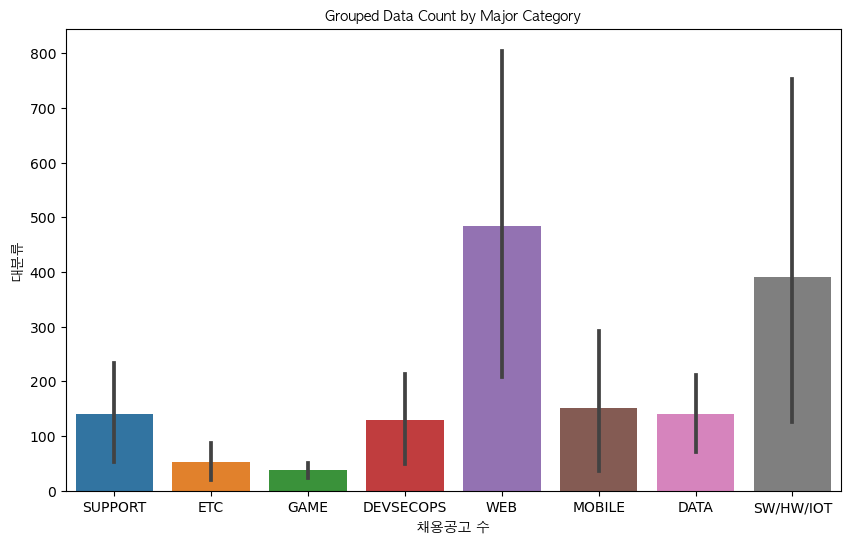

In [137]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm


# Visualize using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_major_category_pd, y='job_id_count', x='major_category')

# Setting the downloaded font 
font_path = "./font/applegothic.ttf"
font_properties = fm.FontProperties(fname=font_path)

# Use the font properties for Korean characters
plt.title('Grouped Data Count by Major Category', fontproperties=font_properties)
plt.ylabel('대분류', fontproperties=font_properties)
plt.xlabel('채용공고 수', fontproperties=font_properties)

plt.rc('axes', unicode_minus=False)
plt.show()

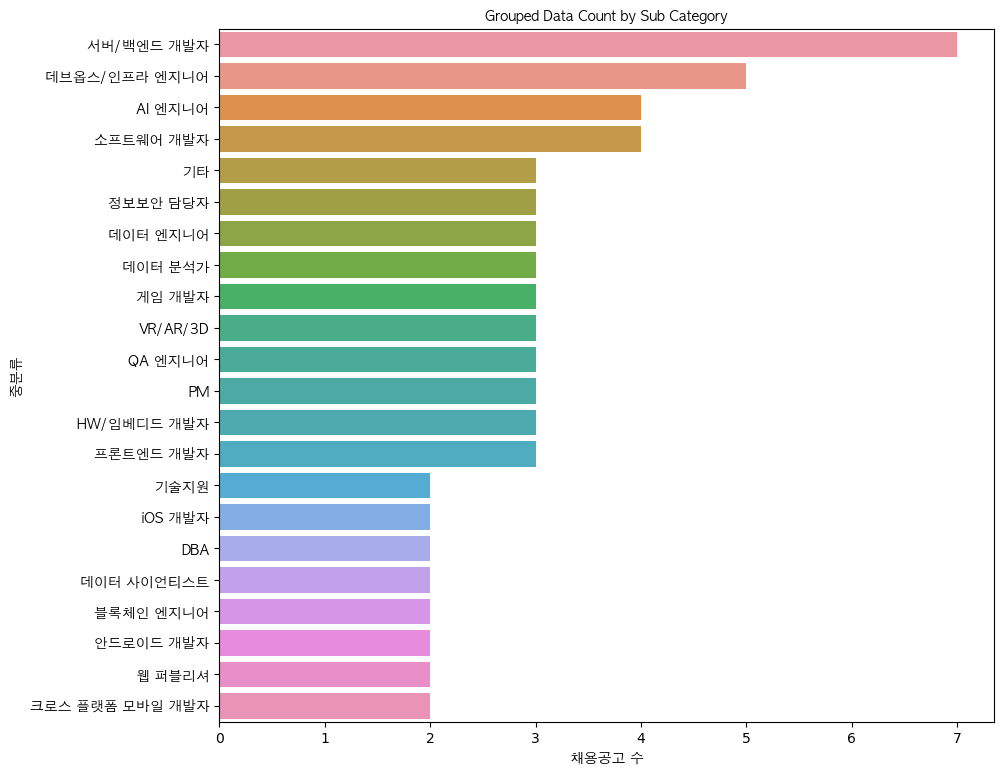

In [146]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Convert to pandas DataFrame if necessary
# grouped_major_category_pd = group_category.toPandas()

# Group by sub-category
grouped_df_sub_category = grouped_major_category_pd.groupby('middle_category').size().reset_index(name='job_id_count').sort_values('job_id_count', ascending=False)

# Setting the font globally
font_path = "./font/applegothic.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
font_properties = fm.FontProperties(fname=font_path)

# Create the plot
plt.figure(figsize=(10, 9))
sns.barplot(data=grouped_df_sub_category, y='middle_category', x='job_id_count')


# Set y-tick labels manually
ax = plt.gca()
y_labels = ax.get_yticklabels()
ax.set_yticklabels(y_labels, fontproperties=fm.FontProperties(fname=font_path))


plt.title('Grouped Data Count by Sub Category', fontproperties=font_properties)
plt.xlabel('채용공고 수', fontproperties=font_properties)
plt.ylabel('중분류', fontproperties=font_properties)
plt.rc('axes', unicode_minus=False)
plt.show()



### 회사 주소

In [147]:
# Convert to pandas DataFrame
temp_df = new_df.toPandas()

In [148]:
def clean_location_sido(location):
    if location:
        location = location.split()
        if location[0].startswith('주소'):
            location = location[1][:2]
        else:
            location = location[0][:2]
        return location
    else:
        None

In [149]:
temp_df['sido_location'] = temp_df['location'].apply(lambda x: clean_location_sido(x))

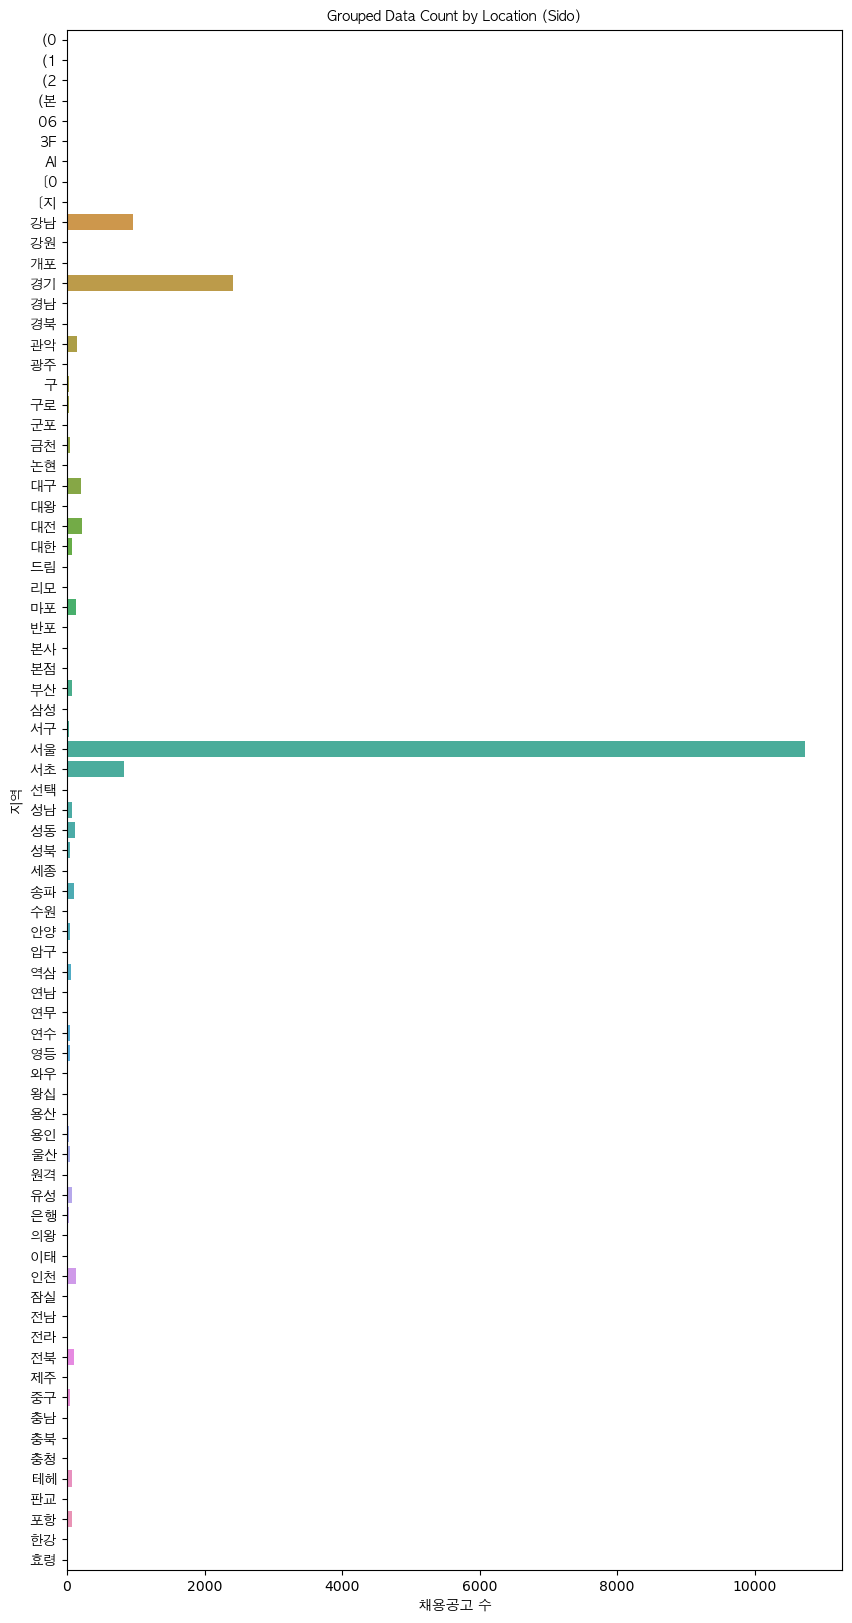

In [156]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Assuming temp_df has already been defined

# Grouping data by 'sido_location'
grouped_df_location = temp_df.groupby('sido_location').size().reset_index(name='count')

# Setting the font path and properties
font_path = "./font/applegothic.ttf"
font_properties = fm.FontProperties(fname=font_path)

# Drawing the bar plot
plt.figure(figsize=(10, 20))
ax = sns.barplot(data=grouped_df_location, y='sido_location', x='count')

# Adjusting y-tick labels for the font
y_labels = ax.get_yticklabels()
ax.set_yticklabels(y_labels, fontproperties=font_properties)

# Setting title and labels with the desired font
plt.title('Grouped Data Count by Location (Sido)', fontproperties=font_properties)
plt.xlabel('채용공고 수', fontproperties=font_properties)
plt.ylabel('지역', fontproperties=font_properties)

# Displaying the plot
plt.show()

In [157]:
def clean_location_gugun(location):
    if location:
        location = location.split()
        if location[0].startswith('주소'):
            location = location[2][:2]
        else:
            if len(location) == 1:
                return None
            location = location[1][:2]
        return location
    else:
        None

In [158]:
temp_df['gugun_location'] = temp_df['location'].apply(lambda x: clean_location_gugun(x))

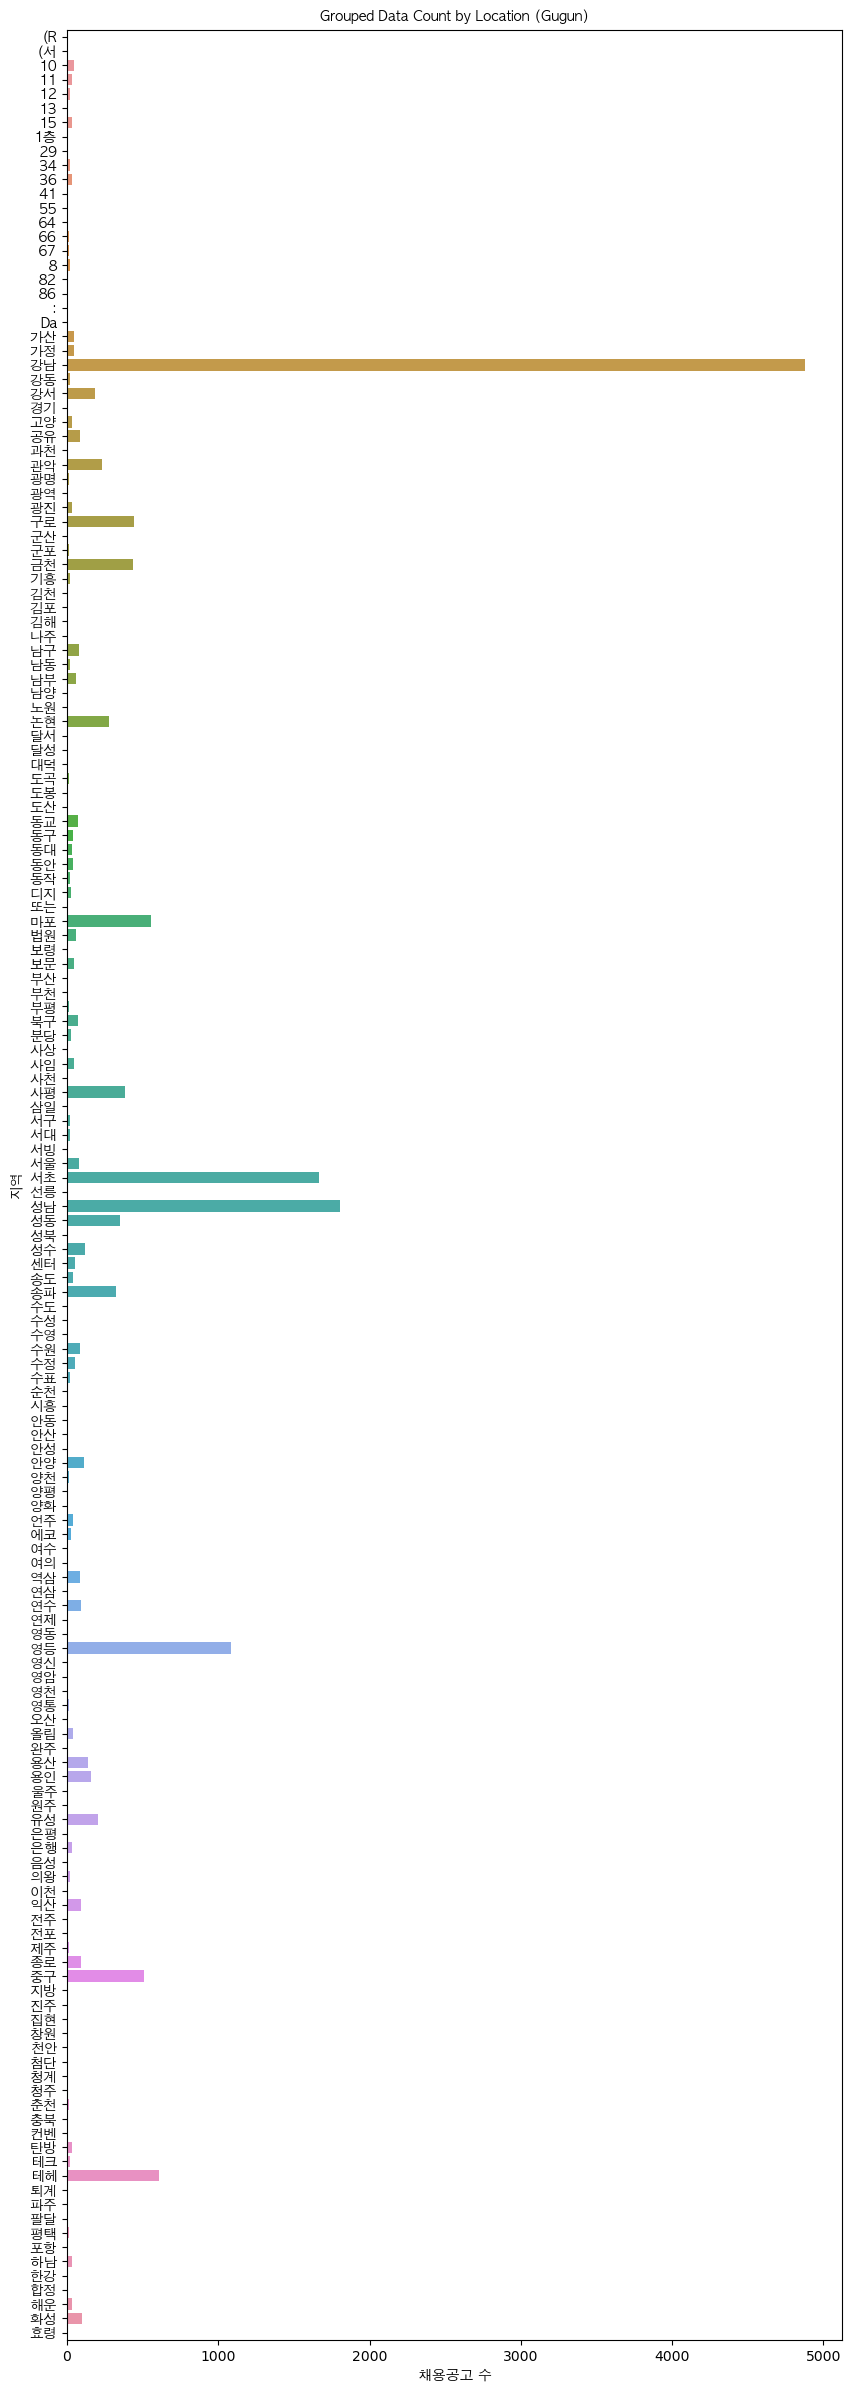

In [160]:
grouped_df_location_gugun = temp_df.groupby('gugun_location').size().reset_index(name='count')

# 그래프 그리기
plt.figure(figsize=(10, 30))
ax = sns.barplot(data=grouped_df_location_gugun, y='gugun_location', x='count')

# Adjusting y-tick labels for the font
y_labels = ax.get_yticklabels()
ax.set_yticklabels(y_labels, fontproperties=font_properties)


plt.title('Grouped Data Count by Location (Gugun)', fontproperties=font_properties)
plt.xlabel('채용공고 수', fontproperties=font_properties)
plt.ylabel('지역', fontproperties=font_properties)
plt.show()

## 키워드 추출

In [161]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.15.0-py3-none-any.whl size=30602630 sha256=695cdad06d9c5a97b7c9408c64080e6953771f02c41dea8e77dbeee3a5b2cad7
  Stored in directory: /home/jovyan/.cache/pip/wheels/f3/55/41/ca474338ece1bc4314b01445f64ff002d71e19df45575a16e2
Successfully built kiwipiepy-model


In [162]:
from kiwipiepy import Kiwi

In [163]:
kiwi = Kiwi()

In [167]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Your extract_noun function
kiwi = Kiwi()

def extract_noun(text):
    nouns = []
    result = kiwi.tokenize(text)
    for token in result:
        if token.tag in ['NNG', 'NNP']:
            nouns.append(token.form)
    return nouns

# Registering the function as a UDF
extract_noun_udf = udf(extract_noun, ArrayType(StringType()))

# Applying the UDF to your Spark DataFrame columns
new_df = new_df.withColumn('cleaned_required', extract_noun_udf(new_df['required']))
new_df = new_df.withColumn('cleaned_primary_responsibility', extract_noun_udf(new_df['primary_responsibility']))
new_df = new_df.withColumn('cleaned_preferred', extract_noun_udf(new_df['preferred']))
new_df = new_df.withColumn('cleaned_welfare', extract_noun_udf(new_df['welfare']))
new_df = new_df.withColumn('cleaned_company_description', extract_noun_udf(new_df['company_description']))

Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/serializers.py", line 458, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/usr/local/spark/python/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/usr/local/spark/python/pyspark/cloudpickle/cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
TypeError: cannot pickle 'Kiwi' object


PicklingError: Could not serialize object: TypeError: cannot pickle 'Kiwi' object